In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import hstack
import random
pd.set_option('display.max_columns', None)
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/My Drive/512_project/data/cleaned_data.csv')
df

,state,county,COUNTYFP,date,new_cases,Face_Masks_Required_in_Public,mask_use
0,Alabama,Montgomery,1101,2020-04-15,190.0,0,0.75725
1,Alabama,Montgomery,1101,2020-04-16,99.5,0,0.75725
2,Alabama,Montgomery,1101,2020-04-17,5.0,0,0.75725
3,Alabama,Montgomery,1101,2020-04-18,7.0,0,0.75725
4,Alabama,Montgomery,1101,2020-04-19,11.5,0,0.75725
...,...,...,...,...,...,...,...
448945,Wisconsin,Wood,55141,2021-04-10,10.0,0,0.58350
448946,Wisconsin,Wood,55141,2021-04-11,15.5,0,0.58350
448947,Wisconsin,Wood,55141,2021-04-12,12.0,0,0.58350
448948,Wisconsin,Wood,55141,2021-04-13,3.5,0,0.58350


# Multivariate data preparation

In [4]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(0, len(sequences), n_steps):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), np.expand_dims(y, axis=1)

# Split Data Into Train/Test
Also leave out all counties named 'Wayne' for all states. This is the validation set I will use in another notebook that the pretrained model saved from this notebook must not see during training time.

In [5]:
train = df.loc[~df['county'].isin(['Wayne', 'Montgomery', 'Wood', 'King', 'Columbia', 'Washington', 'Jefferson'])]

In [6]:
test = df.loc[df['county'].isin(['King', 'Montgomery', 'Wood', 'Columbia', 'Washington', 'Jefferson'])]

In [7]:
train.shape

(427050, 7)

In [8]:
test.shape

(16790, 7)

# Create a dataset

In [9]:
train_np = train[['new_cases', 'Face_Masks_Required_in_Public', 'mask_use']].to_numpy()
test_np = test[['new_cases', 'Face_Masks_Required_in_Public', 'mask_use']].to_numpy()
train_np.shape

(427050, 3)

# Create sequences of one year



In [10]:
seq_length = 365

In [11]:
X_train, y_train = split_sequences(train_np, seq_length)
X_test, y_test = split_sequences(test_np, seq_length)

In [12]:
X_train.shape

(1170, 365, 2)

In [13]:
y_train.shape

(1170, 1)

In [14]:
X_test.shape

(46, 365, 2)

# Create DataLoaders for Pytorch

In [15]:
# convert train and test data to tensors
X_train = torch.tensor(X_train, dtype=torch.float)
y_train = torch.tensor(y_train, dtype=torch.float)
X_test = torch.tensor(X_test, dtype=torch.float)
y_test = torch.tensor(y_test, dtype=torch.float)

# use torch tensor datasets
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# get data loaders
batch_size = 16
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [16]:
X_train.shape

torch.Size([1170, 365, 2])

# Create an LSTM model

In [17]:
class MV_LSTM(torch.nn.Module):
    def __init__(self,n_features, seq_length):
        super(MV_LSTM, self).__init__()
        self.n_features = n_features
        self.seq_length = seq_length
        self.n_hidden = 20 # number of hidden states
        self.n_layers = 1 # number of LSTM layers (stacked)
    
        self.l_lstm = torch.nn.LSTM(input_size = n_features, 
                                 hidden_size = self.n_hidden,
                                 num_layers = self.n_layers, 
                                 batch_first = True)
        self.act1 = torch.nn.ReLU()
        # according to pytorch docs LSTM output is 
        # (batch_size,seq_len, num_directions * hidden_size)
        # when considering batch_first = True
        self.l_linear = torch.nn.Linear(self.n_hidden * self.seq_length, 1)
        
    
    def init_hidden(self, batch_size):
        # even with batch_first = True this remains same as docs
        hidden_state = torch.zeros(self.n_layers, batch_size,self.n_hidden)
        cell_state = torch.zeros(self.n_layers, batch_size,self.n_hidden)
        self.hidden = (hidden_state, cell_state)
    
    
    def forward(self, x):        
        batch_size, seq_length, _ = x.size()

        lstm_out, self.hidden = self.l_lstm(x,self.hidden)
        # lstm_out(with batch_first = True) is 
        # (batch_size,seq_len,num_directions * hidden_size)
        # for following linear layer we want to keep batch_size dimension and merge rest       
        # .contiguous() -> solves tensor compatibility error
        x = lstm_out.contiguous().view(batch_size,-1)
        x = self.act1(x)
        return self.l_linear(x)

# Plot Results

In [18]:
def plot_results(losses_train, losses_test):
    fig,ax = plt.subplots(1,2,figsize=[24,4])
    ax[0].plot(losses_train)
    ax[0].set_ylabel('MSE loss train')
    ax[0].set_xlabel('iteration')
    ax[0].set_title('MSE Train Loss')
    ax[1].plot(losses_test)
    ax[1].set_ylabel('MSE loss test')
    ax[1].set_xlabel('iteration')
    ax[1].set_title('MSE Test Loss')

# Initialize the NN

In [19]:
X_train.shape

torch.Size([1170, 365, 2])

In [20]:
# create NN
n_features = int(X_train.shape[2]) # this is number of parallel inputs
mv_net = MV_LSTM(n_features, seq_length)
criterion = torch.nn.MSELoss() # reduction='sum' created huge loss value
optimizer = torch.optim.Adam(mv_net.parameters(), lr=0.1)

epochs = 20

# Training

In [21]:
import time
torch.manual_seed(712)

print("{:<8} {:<25} {:<25} {:<25}".format('Epoch', 
                                      'Train Loss', 
                                      'Test Loss', 
                                      'Time (seconds)'))
total_test_loss = []
total_train_loss = []
for epoch in range(epochs):
    mv_net.train()
    start = time.time()
    epoch_loss = []
    # for batch in train data
    for step, batch in enumerate(train_dataloader):
        # make gradient zero to avoid accumulation
        mv_net.zero_grad()
        inputs, labels = batch
        
        mv_net.init_hidden(inputs.size(0))
        # get predictions
        out = mv_net(inputs)
        # get loss
        loss = criterion(out, labels)
        epoch_loss.append(loss.float().detach().cpu().numpy().mean())
        # backpropagate
        loss.backward()
        optimizer.step()
    test_epoch_loss = []
    end = time.time()
    mv_net.eval()
    # for batch in validation data
    for step, batch in enumerate(test_dataloader):
        inputs, labels = batch

        mv_net.init_hidden(inputs.size(0))
        # get predictions
        out = mv_net(inputs)
        # get loss
        loss = criterion(out, labels)     
        test_epoch_loss.append(loss.float().detach().cpu().numpy().mean())
    print("{:<8} {:<25} {:<25} {:<25}".format(epoch+1, 
                                              np.mean(epoch_loss), 
                                              np.mean(test_epoch_loss), 
                                              end-start))
    total_test_loss.append(np.mean(test_epoch_loss))
    total_train_loss.append(np.mean(epoch_loss))

    # if this is the current best model on the test set, save the model
    if len(total_test_loss) == 1 or total_test_loss[-1] < min(total_test_loss[0:-1]):
      state = {'state_dict':mv_net.state_dict(),
                'epoch':len(total_test_loss),
                'loss':total_test_loss[-1],
                'n_features':n_features,
                'seq_length':seq_length}
      torch.save(state, '/content/drive/My Drive/512_project/models/model.pt')


Epoch    Train Loss                Test Loss                 Time (seconds)           
1        158.68341064453125        1.3960657119750977        12.242981910705566       
2        0.9606342911720276        0.7185661792755127        6.883168697357178        
3        0.32353532314300537       0.8267436623573303        6.201373100280762        
4        0.1452372819185257        0.7730423808097839        5.982965469360352        
5        0.0864391028881073        0.6755412220954895        6.680647373199463        
6        0.05743220075964928       0.7110597491264343        6.79901385307312         
7        0.040463365614414215      0.6928496360778809        6.0475640296936035       
8        0.0335971936583519        0.6567597985267639        6.037728786468506        
9        0.031492680311203         0.8227551579475403        6.2367613315582275       
10       0.04466927424073219       0.3925303518772125        6.321821451187134        
11       0.08430135995149612       0.623993

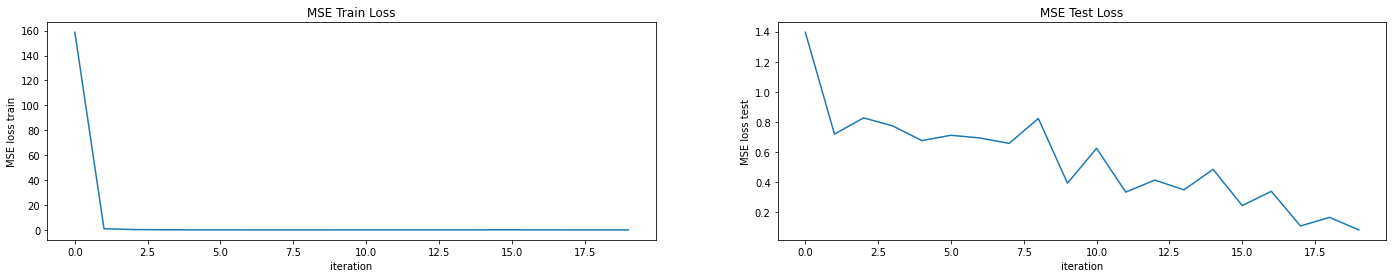

In [22]:
plot_results(total_train_loss, total_test_loss)